In [19]:
#Script publicador

import ssl
import sys
import json
import random
import time
import paho.mqtt.client
import paho.mqtt.publish
import numpy as np
import datetime
import math
import psycopg2
from randmac import RandMac


def on_connect(client, userdata, flags, rc):
    print('Publicando')


def main():
    conn = psycopg2.connect(host='bydl8yhl1xvycflftlju-postgresql.services.clever-cloud.com', user='ujegvu5yu2q28i5dthj9', password='86WWh0iQz4n8dfN82WGW', dbname='bydl8yhl1xvycflftlju')
    cursor = conn.cursor()
    conn.autocommit = True
  
    client = paho.mqtt.client.Client("Pipo-subs", False)
    client.qos = 0
    client.connect(host='localhost')
    
    while(True):
        random = int(np.random.uniform(0, 2))
        if (random == 1):
            sexo = 'masculino'
        else:
            sexo = 'femenino'

        random = int(np.random.uniform(0, 2))
        tiene_telefono = False
        macaddress = None
        if (random == 1):
            tiene_telefono = True
            macaddress = str(RandMac("00:00:00:00:00:00", False))
            macaddress = macaddress.replace("'", "")
            
        edad = int(np.random.uniform(10, 60))
        hora_entrada = time.strftime("%d/%m/%y %H:%M:%S")
        id_camara = int(np.random.uniform(1, 4))
        id_persona = int(np.random.uniform(1000000, 50000000))
        
        payload = {
            "id_camara": id_camara,
            "hora_entrada": hora_entrada,
            "hora_salida": None,
            "id_persona": id_persona,
            "macaddress": macaddress
        }
        
        # Crear Persona en la BDD
        query = "INSERT INTO persona (id, sexo, edad) VALUES (%s, %s, %s);"
        cursor.execute(query, (id_persona, sexo, edad))
        conn.commit()

        # Crear Registro de teléfono en caso de que tenga teléfono
        if (tiene_telefono == True):
            query = "INSERT INTO telefono (macaddress, id_persona) VALUES (%s, %s);"
            cursor.execute(query, (macaddress, id_persona))
            conn.commit()
        
        client.publish('sambil/accesos', json.dumps(payload), qos=0)

        time.sleep(np.random.uniform(2, 4))


if __name__ == '__main__':
    main()

sys.exit(0)

ModuleNotFoundError: No module named 'randmac'

In [21]:
#Script Subscriptor

import ssl
import sys
import json
import paho.mqtt.client
import psycopg2


conn = psycopg2.connect(host='bydl8yhl1xvycflftlju-postgresql.services.clever-cloud.com',
                        user='ujegvu5yu2q28i5dthj9', password='86WWh0iQz4n8dfN82WGW', dbname='bydl8yhl1xvycflftlju')


def doQuery(a):
    a = a.decode('utf-8').replace("'", '"')
    a = json.loads(a)
    
    id_camara = a['id_camara']
    hora_entrada = a['hora_entrada']
    hora_salida = a['hora_salida']
    id_persona = a['id_persona']
    macaddress = a['macaddress']

    cur = conn.cursor()
    sql = "INSERT INTO estadistica_camara (id_camara, hora_entrada, hora_salida, id_persona, dentro_tienda, sentado_mesa, rip) VALUES (%s, %s, %s, %s, %s, %s, %s);"
    cur.execute(sql, (id_camara, hora_entrada, hora_salida, id_persona, False, False, False))
    conn.commit()
    if (macaddress != None):
        print('ENTRA -> persona con cédula ', id_persona, ' al CENTRO COMERCIAL y con el teléfono ', macaddress)
    else:
        print('ENTRA -> persona con cédula ', id_persona, ' al CENTRO COMERCIAL')

def on_connect(client, userdata, flags, rc):
    print("Conectado! (%s)" % client._client_id)
    client.subscribe(topic='sambil/#', qos=0)


def on_message(client, userdata, message):
    doQuery(message.payload)

    

def main():
    client = paho.mqtt.client.Client()
    client.on_connect = on_connect
    client.message_callback_add('sambil/accesos', on_message)
    client.connect(host='localhost')
    client.loop_forever()


if __name__ == '__main__':
    main()

sys.exit(0)

Conectado! (b'')
ENTRA -> persona con cédula  4911822  al CENTRO COMERCIAL
ENTRA -> persona con cédula  14771527  al CENTRO COMERCIAL y con el teléfono  00:00:00:28:6a:af
ENTRA -> persona con cédula  31100107  al CENTRO COMERCIAL
ENTRA -> persona con cédula  3837745  al CENTRO COMERCIAL y con el teléfono  00:00:00:89:8c:3e
ENTRA -> persona con cédula  5930294  al CENTRO COMERCIAL
ENTRA -> persona con cédula  39631021  al CENTRO COMERCIAL
ENTRA -> persona con cédula  6018540  al CENTRO COMERCIAL y con el teléfono  00:00:00:ab:0a:70
ENTRA -> persona con cédula  12058107  al CENTRO COMERCIAL y con el teléfono  00:00:00:b4:1d:5f
ENTRA -> persona con cédula  47639712  al CENTRO COMERCIAL y con el teléfono  00:00:00:83:0e:fb
ENTRA -> persona con cédula  35233363  al CENTRO COMERCIAL y con el teléfono  00:00:00:a7:3f:cf
ENTRA -> persona con cédula  18065180  al CENTRO COMERCIAL y con el teléfono  00:00:00:82:a8:1d
ENTRA -> persona con cédula  40597276  al CENTRO COMERCIAL
ENTRA -> persona con

KeyboardInterrupt: 

In [22]:
#Script simulacion de data en el centro comercial

import sys
import json
import paho.mqtt.client
import psycopg2
import numpy as np
import math
import random
import datetime
import time

conn = psycopg2.connect(host='bydl8yhl1xvycflftlju-postgresql.services.clever-cloud.com',
                        user='ujegvu5yu2q28i5dthj9', password='86WWh0iQz4n8dfN82WGW', dbname='bydl8yhl1xvycflftlju')

# -------------------------------------------------------------
#  -------------------------- QUERYS --------------------------
# -------------------------------------------------------------
def doQueryPersonasEnPasillo():
    cur = conn.cursor()
    sql = "SELECT * FROM estadistica_camara WHERE dentro_tienda = false AND sentado_mesa = false AND rip = false GROUP BY id;"
    cur.execute(sql)
    records = cur.fetchall()
    return records

def doQueryCantidadEnCadaTienda():
    cur = conn.cursor()
    sql = "SELECT id_tienda, COUNT(id_tienda) FROM estadistica_tienda WHERE rip = false GROUP BY id_tienda HAVING COUNT(id_tienda) > 0 ORDER BY id_tienda;"
    cur.execute(sql)
    records = cur.fetchall()
    return records

def doQueryPersonasEnTienda(id_tienda):
    cur = conn.cursor()
    sql = "SELECT id_persona FROM estadistica_tienda WHERE rip = false AND id_tienda = %s;"
    cur.execute(sql, [id_tienda])
    records = cur.fetchall()
    return records

def doQueryMesasOcupadas():
    cur = conn.cursor()
    sql = "SELECT id_mesa FROM estadistica_mesa WHERE rip = false ORDER BY id_mesa;"
    cur.execute(sql)
    records = cur.fetchall()
    return records

def doQueryMeterEnTienda(id_persona, id_tienda):
    cur = conn.cursor()
    sql = "UPDATE estadistica_camara SET dentro_tienda = true WHERE id_persona = '%s';"
    cur.execute(sql, [id_persona])
    sql = "INSERT INTO estadistica_tienda (id_tienda, id_persona, rip) VALUES (%s, %s, %s)"
    cur.execute(sql, (id_tienda, id_persona, False))
    conn.commit()
    print('ENTRA -> persona con cédula ', id_persona, ' a la tienda con id ', id_tienda)

def doQuerySacarDeTienda(id_persona, id_tienda):
    cur = conn.cursor()
    sql = "UPDATE estadistica_tienda SET rip = true WHERE id_persona = %s AND id_tienda = %s AND rip = false;"
    cur.execute(sql, (id_persona, id_tienda))
    sql = "UPDATE estadistica_camara SET dentro_tienda = false WHERE id_persona = '%s';"
    cur.execute(sql, [id_persona])
    conn.commit()
    print('SALE -> persona con cédula ', id_persona, ' de la tienda con id ', id_tienda)

def doQuerySentarEnMesa(id_persona, id_mesa, hora_entrada):
    cur = conn.cursor()
    sql = "UPDATE estadistica_mesa SET rip = false, hora_entrada = %s, id_persona = %s, hora_salida = null WHERE id_mesa = %s;"
    cur.execute(sql, (hora_entrada, id_persona, id_mesa))
    if(id_persona != None):
        sql = "UPDATE estadistica_camara SET sentado_mesa = true WHERE id_persona = '%s';"
        cur.execute(sql, [id_persona])
    conn.commit()
    print('SE Sento -> persona con cédula ', id_persona, ' en la mesa con id ', id_mesa)

def doQueryTieneTelefono(id_persona):
    cur = conn.cursor()
    sql = "SELECT * FROM telefono WHERE id_persona = %s;"
    cur.execute(sql, [id_persona])
    conn.commit()
    records = cur.fetchall()
    return records

def doQueryPersonasEnMesa(id_mesa):
    cur = conn.cursor()
    sql = "SELECT id_persona FROM estadistica_mesa WHERE id_mesa = %s;"
    cur.execute(sql, [id_mesa])
    records = cur.fetchall()
    return records

def doQueryPararDeMesa(id_mesa, id_persona, hora_salida):
    cur = conn.cursor()
    sql = "UPDATE estadistica_mesa SET hora_salida = %s, rip = true WHERE id_mesa = %s;"
    cur.execute(sql, (hora_salida, id_mesa))
    if(id_persona != None):
        sql = "UPDATE estadistica_camara SET sentado_mesa = false WHERE id_persona = '%s';"
        cur.execute(sql, [id_persona])
    conn.commit()
    print('SE Paro -> persona con cédula ', id_persona, ' de la mesa con id ', id_mesa)

def doQueryRealizarVenta(id_tienda, id_persona, monto):
    cur = conn.cursor()
    sql = "INSERT INTO venta (id_tienda, id_persona, monto) VALUES (%s, %s, %s)"
    cur.execute(sql, (id_tienda, id_persona, monto))
    conn.commit()
    print('COMPRA -> persona con cédula ', id_persona, ' a la tienda con id ', id_tienda, ' por un monto ', monto)

def doQuerySacarDelCC(id_persona):
    cur = conn.cursor()
    sql = "UPDATE estadistica_camara SET rip = true WHERE id_persona = '%s' and rip = false;"
    cur.execute(sql, [id_persona])
    conn.commit()
    print('SALE -> persona con cédula ', id_persona, ' del centro comercial')


# -------------------------------------------------------------
#  ------------------------ FUNCIONES -------------------------
# -------------------------------------------------------------
def meterPersonaEnTienda():
    personas_en_pasillo_query = doQueryPersonasEnPasillo()
    personas_en_pasillo = []
    # Obtenemos las cédulas de las personas que están en los pasillos
    for row in personas_en_pasillo_query:
        personas_en_pasillo.append(row[4])
    cantidad = len(personas_en_pasillo)
    random = int(np.random.uniform(0, cantidad)) # Lugar en el array de la persona que meteremos en una tienda
    id_tienda_para_meter = int(np.random.uniform(1, 4)) # ID de la tienda en lña que vamos a meter
    cont = 0

    for row in personas_en_pasillo:
        if (cont == random):
            id_persona_para_meter = row
        cont+=1

    # Si hay gente en los pasillos, meter a una persona en la tienda
    if (len(personas_en_pasillo) > 0):
        doQueryMeterEnTienda(id_persona_para_meter, id_tienda_para_meter)

def sacarPersonEnTienda():
    tienda_a_sacar_query = doQueryCantidadEnCadaTienda()
    random.shuffle(tienda_a_sacar_query)
    tienda_a_sacar = tienda_a_sacar_query[0]
    id_tienda_a_sacar = tienda_a_sacar[0]
    #cant_tienda_a_sacar = tienda_a_sacar[1]

    personas_en_tienda = doQueryPersonasEnTienda(id_tienda_a_sacar)
    random.shuffle(personas_en_tienda)
    id_persona_a_sacar = personas_en_tienda[0][0]

    doQuerySacarDeTienda(id_persona_a_sacar, id_tienda_a_sacar)

def sentarPersonaEnMesa():
    personas_en_pasillo_query = doQueryPersonasEnPasillo()
    personas_en_pasillo = []

    # Obtenemos las cédulas de las personas que están en los pasillos
    for row in personas_en_pasillo_query:
        personas_en_pasillo.append(row[4])

    cantidad = len(personas_en_pasillo)
    randomPersona = int(np.random.uniform(0, cantidad)) # Lugar en el array de la persona que sentaremos en una mesa

    cont = 0
    for row in personas_en_pasillo:
        if (cont == randomPersona):
            id_persona_para_sentar = row
        cont+=1

    id_mesas_ocupadas_query = doQueryMesasOcupadas()
    id_mesas_ocupadas = []
    id_mesas_desocupadas = []
    for id in id_mesas_ocupadas_query:
        id_mesas_ocupadas.append(id[0])

    for i in range(0, 9):
        if (not find(id_mesas_ocupadas, i + 1)):
            id_mesas_desocupadas.append(i + 1)  

    hora_entrada = time.strftime("%d/%m/%y %H:%M:%S")        
            
    random.shuffle(id_mesas_desocupadas)
    id_mesa_para_sentar = id_mesas_desocupadas[0]

    verificarTelefono(id_persona_para_sentar) #chequea si el id de la persona corresponde a una con telefono

    if(not verificarTelefono): #si no tiene telefono no guarda el id en la mesa
        id_persona_para_sentar = None


    doQuerySentarEnMesa(id_persona_para_sentar, id_mesa_para_sentar , hora_entrada)

def pararPersonaDeMesa():
    mesas_ocupadas = doQueryMesasOcupadas() #se elige una mesa que este ocupada
    random.shuffle(mesas_ocupadas)
    mesa_a_desocupar = mesas_ocupadas[0][0]

    persona_a_parar = doQueryPersonasEnMesa(mesa_a_desocupar)
    hora_salida = time.strftime("%d/%m/%y %H:%M:%S")
    persona_a_parar = persona_a_parar[0][0]
    doQueryPararDeMesa(mesa_a_desocupar, persona_a_parar, hora_salida)

def realizarVenta():
    tienda_a_vender_query = doQueryCantidadEnCadaTienda() #selecciona que tienda va a realizar una venta
    random.shuffle(tienda_a_vender_query)
    id_tienda_a_vender = tienda_a_vender_query[0][0]

    personas_en_tienda = doQueryPersonasEnTienda(id_tienda_a_vender) #selecciona que persona dentro de la tienda va a comprar
    random.shuffle(personas_en_tienda)
    id_persona_a_comprar = personas_en_tienda[0][0]

    verificarTelefono(id_persona_a_comprar)
    if(verificarTelefono != True): #si no tiene telefono no adjudica la venta a un id
        id_persona_a_comprar = None

    monto = np.random.uniform(100, 50000000)
    monto = round(monto, 2)

    doQueryRealizarVenta(id_tienda_a_vender,id_persona_a_comprar, monto)

def sacarPersonaEnCC():
    personas_en_pasillo_query = doQueryPersonasEnPasillo()
    random.shuffle(personas_en_pasillo_query)
    if (len(personas_en_pasillo_query) > 0):
        persona_a_sacar_cc = personas_en_pasillo_query[0][4]
        doQuerySacarDelCC(persona_a_sacar_cc)

def find(array, value):
    for val in array:
        if (val == value):
            return True
    return False

def verificarTelefono(id_persona):
    chequeo = doQueryTieneTelefono(id_persona)
    if(len(chequeo) > 0):
        return True
    return False

def main():
    
    while(True):
        random = int(np.random.uniform(0, 2))
        if (random == 1):
            meterPersonaEnTienda()
        random = int(np.random.uniform(0, 2))
        if (random == 1):
            sacarPersonEnTienda()
        random = int(np.random.uniform(0, 2))
        if (random == 1):
            sentarPersonaEnMesa()
        random = int(np.random.uniform(0, 2))
        if (random == 1):
            pararPersonaDeMesa()
        random = int(np.random.uniform(0, 2))
        if (random == 1):
            realizarVenta()
        random = int(np.random.uniform(0, 4))
        if (random == 1):
            sacarPersonaEnCC()
        time.sleep(3)

if __name__ == '__main__':
    main()
sys.exit(0)


SE Sento -> persona con cédula  29692187  en la mesa con id  7
SE Paro -> persona con cédula  6750669  de la mesa con id  8
COMPRA -> persona con cédula  None  a la tienda con id  1  por un monto  42322681.96


StatementTooComplex: stack depth limit exceeded
HINT:  Increase the configuration parameter "max_stack_depth" (currently 2048kB), after ensuring the platform's stack depth limit is adequate.
CONTEXT:  SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement
SQL statement "insert into estadistica_tienda values(new.id, new.id_tienda, new.id_persona, new.rip)"
PL/pgSQL function verificar_venta() line 5 at SQL statement


,count,id_persona,sexo,edad
0,1,30203410,femenino,58
1,1,23368002,masculino,20
2,1,33673137,femenino,41
3,1,30072286,femenino,11
4,1,17384597,femenino,25


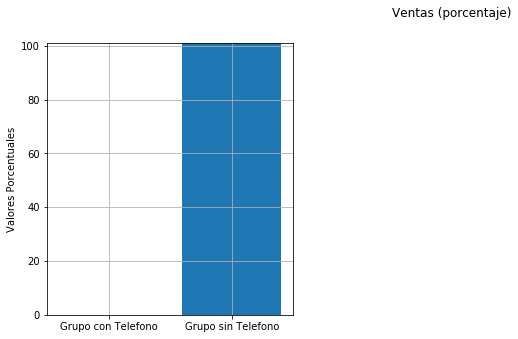

In [17]:
#Graficas y tablas

import matplotlib
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd

conn = psycopg2.connect(host='bydl8yhl1xvycflftlju-postgresql.services.clever-cloud.com',
                        user='ujegvu5yu2q28i5dthj9', password='86WWh0iQz4n8dfN82WGW', dbname='bydl8yhl1xvycflftlju')

cur = conn.cursor()
sql = "SELECT COUNT(id) FROM venta WHERE id_persona IS NOT null;"
cur.execute(sql)
conTel = cur.fetchall()
conTel = conTel[0][0]

cur = conn.cursor()
sql = "SELECT COUNT(id) FROM venta WHERE id_persona IS null;"
cur.execute(sql)
sinTel = cur.fetchall()
sinTel = sinTel[0][0]

total = conTel + sinTel


names = ['Grupo con Telefono', 'Grupo sin Telefono']
values = [(conTel/2)*100, (sinTel/2)*100]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.bar(names, values)
plt.grid(True)
plt.ylabel('Valores Porcentuales')
plt.suptitle('Ventas (porcentaje)')
plt.axis([-0.5, 1.5, 0 , 101])
plt.show


sql = '''
    SELECT * FROM mas_visitas;
'''

df = pd.read_sql(sql, conn)
df

<function matplotlib.pyplot.show(*args, **kw)>

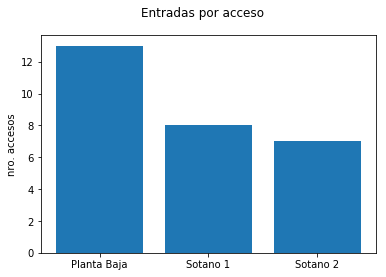

In [6]:
#tabla con numero de accesos
import psycopg2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

conn = psycopg2.connect(host='bydl8yhl1xvycflftlju-postgresql.services.clever-cloud.com',
                        user='ujegvu5yu2q28i5dthj9', password='86WWh0iQz4n8dfN82WGW', dbname='bydl8yhl1xvycflftlju')

cur = conn.cursor()
sql = '''
    select * from numero_accesos WHERE camara = 1;
'''
cur.execute(sql)
pb = cur.fetchall()
pb = pb[0][0]

cur = conn.cursor()
sql = '''
    select * from numero_accesos WHERE camara = 2;
'''
cur.execute(sql)
s1 = cur.fetchall()
s1 = s1[0][0]

cur = conn.cursor()
sql = '''
    select * from numero_accesos WHERE camara = 3;
'''
cur.execute(sql)
s2 = cur.fetchall()
s2 = s2[0][0]

names= ['Planta Baja', 'Sotano 1', 'Sotano 2']
values=[pb, s1, s2]
plt.bar(names, values)
plt.ylabel('nro. accesos')
plt.suptitle('Entradas por acceso')
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

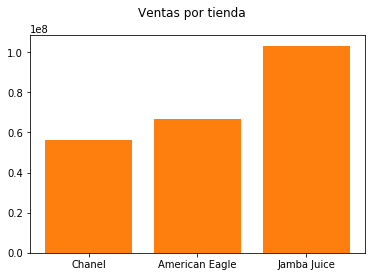

In [24]:
#tabla ventas por local

import psycopg2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.axes.Axes.pie
matplotlib.pyplot.pie

conn = psycopg2.connect(host='bydl8yhl1xvycflftlju-postgresql.services.clever-cloud.com',
                        user='ujegvu5yu2q28i5dthj9', password='86WWh0iQz4n8dfN82WGW', dbname='bydl8yhl1xvycflftlju')

cur = conn.cursor()
sql = '''
    SELECT * from ventas_tienda;
'''
cur.execute(sql)
pb = cur.fetchall()
num1 = pb[0][0]
num2 = pb[1][0]
num3 = pb[2][0]
var1 = pb[0][1]
var2 = pb[1][1]
var3 = pb[2][1]


names= [var1, var2, var3]
values=[num1, num2, num3]
plt.bar(names, values)

plt.bar(names, values)
plt.suptitle('Ventas por tienda')
plt.show